In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn, get_image_coordinates
from model.layers.Spline import NaturalCubicSpline

In [7]:
tfrecord_path = '../../data1/waymo_dataset/uncompressed/tf_example/validation'
idx_path = '../../idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: waymo_collate_fn(x))
road_map, agent_trajectories, unobserved_positions, future_times, target_velocity, target_occupancy_grid = next(iter(dataloader))

(224, 224, 3)


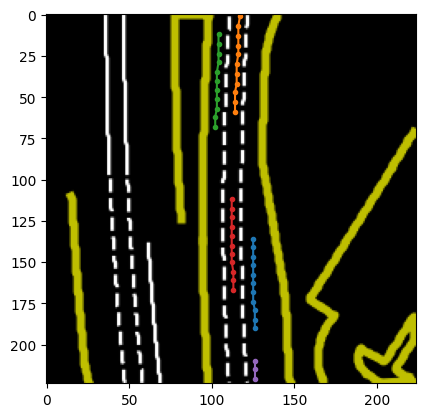

In [8]:
image_buffer = road_map[0].numpy() / 255.0
print(image_buffer.shape)

plt.imshow(image_buffer)
#plt.axis('off')

trajectories = get_image_coordinates(agent_trajectories[:,:,:,:2])[0]
for agent in range(trajectories.shape[0]):
    agent_trajectory = trajectories[agent, :, :]
    count_non_nan = torch.sum(torch.isnan(agent_trajectory) == False).item()
    plt.plot(agent_trajectory[:, 0], agent_trajectory[:, 1], marker='o', markersize=3)

plt.show()

/tmp/ipykernel_164556/743861319.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


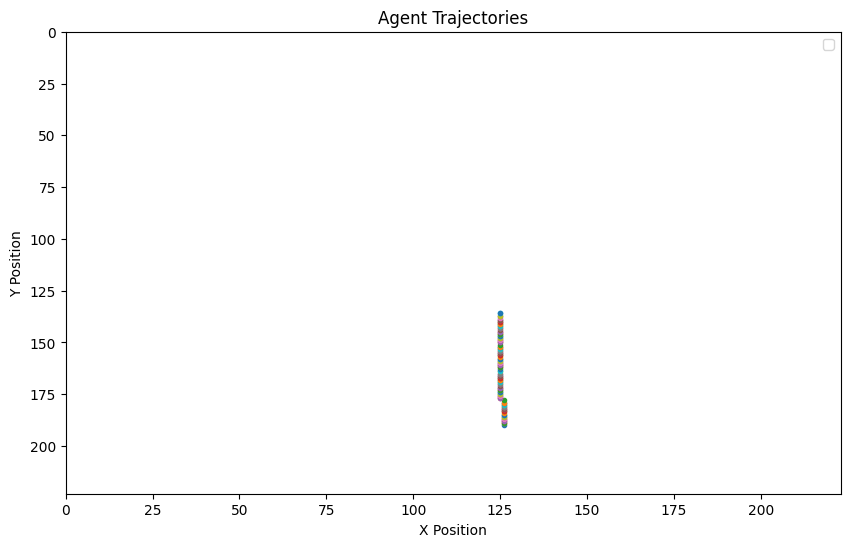

In [12]:
trajectories = agent_trajectories[:,:,:,:2]
batch, num_agents, seq_len, num_features = trajectories.shape
t = torch.linspace(0., 1., seq_len).to(agent_trajectories)
spline = NaturalCubicSpline(t, trajectories)

plt.figure(figsize=(10, 6))

SAMPLING_FREQUENCY = 100
for i in range(SAMPLING_FREQUENCY+1):
    t = i / SAMPLING_FREQUENCY
    positions = get_image_coordinates(spline.evaluate(t))
    plt.plot(positions[0,0,0].cpu().numpy(), positions[0,0,1].cpu().numpy(), 'o-', markersize=3)

plt.xlim(0, 223)
plt.ylim(0, 223)

plt.gca().invert_yaxis()

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectories')
plt.legend()
plt.show()